In [1]:
# --------------------------------------------
# 1. Setup and Imports
# --------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Settings
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# -------------------------------------------------
# 2. Load Data and Parse 'date'
# -------------------------------------------------
# Load both train.csv and windforecasts_wf1.csv
train = pd.read_csv("train.csv")
wf1 = pd.read_csv("windforecasts_wf1.csv")

# Convert 'date' from YYYYMMDDHH to datetime in both DataFrames
train['datetime'] = pd.to_datetime(train['date'].astype(str), format='%Y%m%d%H')
wf1['datetime'] = pd.to_datetime(wf1['date'].astype(str), format='%Y%m%d%H')

# Merge on 'datetime' and 'hors' (if hors exists in both, otherwise just 'datetime')
if 'hors' in train.columns and 'hors' in wf1.columns:
    df = pd.merge(train, wf1, on=['datetime', 'hors'], how='inner', suffixes=('', '_wf1'))
else:
    df = pd.merge(train, wf1, on='datetime', how='inner', suffixes=('', '_wf1'))

# Set datetime as index (optional, but useful for time series)
df.set_index('datetime', inplace=True)

# Drop the old 'date' columns if not needed
df.drop(columns=[col for col in ['date', 'date_wf1'] if col in df.columns], inplace=True)

df.head()

# --------------------------------------------
# 2. Basic Info and Structure
# --------------------------------------------
print("Data Shape:", df.shape)
df.info()
df.describe()



Matplotlib is building the font cache; this may take a moment.


Data Shape: (75072, 12)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 75072 entries, 2009-07-01 00:00:00 to 2012-06-26 12:00:00
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wp1     75072 non-null  float64
 1   wp2     75072 non-null  float64
 2   wp3     75072 non-null  float64
 3   wp4     75072 non-null  float64
 4   wp5     75072 non-null  float64
 5   wp6     75072 non-null  float64
 6   wp7     75072 non-null  float64
 7   hors    75072 non-null  int64  
 8   u       75072 non-null  float64
 9   v       75072 non-null  float64
 10  ws      75072 non-null  float64
 11  wd      75072 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 7.4 MB


,wp1,wp2,wp3,wp4,wp5,wp6,wp7,hors,u,v,ws,wd
count,75072.000000,75072.000000,75072.000000,75072.000000,75072.000000,75072.000000,75072.000000,75072.000000,75072.000000,75072.000000,75072.000000,75072.000000
mean,0.235801,0.272691,0.328029,0.274024,0.270842,0.273751,0.280513,24.500000,1.590747,-0.127251,4.077005,144.833257
std,0.233203,0.274257,0.316350,0.289920,0.293654,0.280313,0.305615,13.853491,3.073892,2.870548,1.900838,92.962885
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-9.240000,-10.850000,0.010000,0.020000
25%,0.050000,0.048000,0.059000,0.017000,0.035000,0.053000,0.000000,12.750000,-0.430000,-2.250000,2.760000,73.620000
50%,0.165000,0.175000,0.208000,0.176000,0.157000,0.171000,0.152000,24.500000,1.910000,-0.220000,3.660000,122.770000
75%,0.351000,0.423000,0.543000,0.441000,0.415000,0.437250,0.480000,36.250000,3.510000,2.030000,5.110000,196.805000
max,0.942000,0.979000,0.978000,0.986000,0.966000,0.961000,0.960000,48.000000,15.250000,10.710000,15.810000,359.990000


## Feature Selection

We use the following features for the baseline models:
- `wp1`: Power output of wind park 1 (used as the main feature)
- Optionally, additional features from wind forecasts (e.g., `u`, `v`, `ws`, `wd`) can be included for improved models.

The target variable is the next-hour value of `wp1`, making this a one-step-ahead regression problem.


## Model Choice

We use two baseline models for wind power prediction:
- A simple Sequential Neural Network (MLP) for regression
- Linear Regression as a classical baseline

The neural network is chosen for its ability to capture non-linear relationships, while linear regression provides a transparent, interpretable baseline for comparison.


# Baseline Model: Wind Power Prediction

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [2]:
# -------------------------------------------------
# 4. Check for Missing Values and Duplicates
# -------------------------------------------------
print("Missing values:\n", df.isnull().sum())
print("Duplicated rows:", df.duplicated().sum())


Missing values:
 wp1     0
wp2     0
wp3     0
wp4     0
wp5     0
wp6     0
wp7     0
hors    0
u       0
v       0
ws      0
wd      0
dtype: int64
Duplicated rows: 0


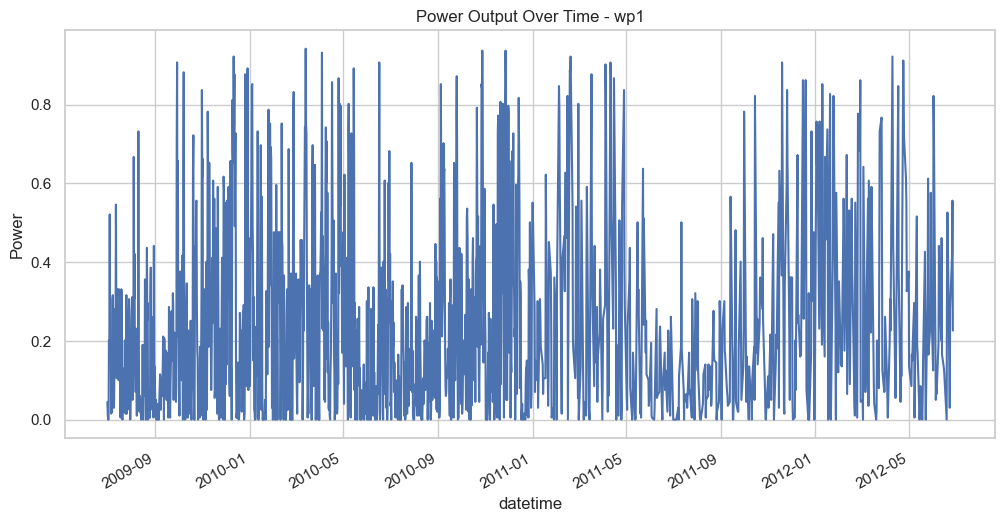

In [3]:
# -------------------------------------------------
# 5. Power Output Over Time (Example: wp1)
# -------------------------------------------------
df['wp1'].plot(title='Power Output Over Time - wp1', ylabel='Power')
plt.show()


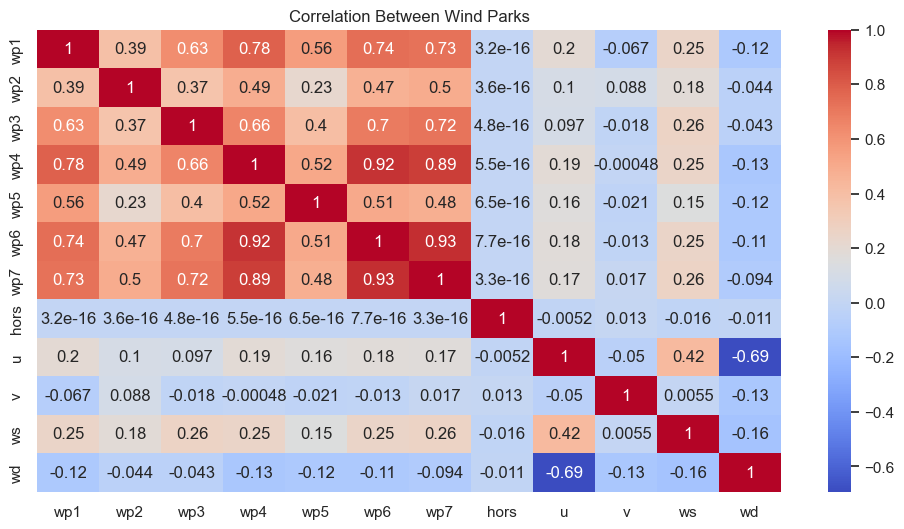

In [4]:
# -------------------------------------------------
# 6. Correlation Check Between Wind Parks
# -------------------------------------------------
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Wind Parks")
plt.show()


In [5]:
#Preprocessing 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


# Taking just one coloumn to create a simplified baseline model
data = df[['wp1']].copy()


# Create shifted target column for next-hour prediction
data['target'] = data['wp1'].shift(-1)
data.dropna(inplace=True)  # Drop the last row with no label

# data['target'].values


## Implementation

Below, we preprocess the data, split it into training and test sets, and implement both the neural network and linear regression models for wind power prediction.


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(data[['wp1']])
y = data['target'].values


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # Important: no shuffling in time series!
)


In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1)  # Output: regression
])

model.compile(optimizer='adam', loss='mse' ,  metrics=['mae'])
model.summary()


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609 (2.38 KB)

 Trainable params: 609 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2)


Epoch 1/30
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 1s 387us/step - loss: 0.0120 - mae: 0.0438 - val_loss: 0.0018 - val_mae: 0.0103
Epoch 2/30
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 1s 352us/step - loss: 0.0010 - mae: 0.0073 - val_loss: 0.0018 - val_mae: 0.0063
Epoch 3/30
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 1s 357us/step - loss: 9.9762e-04 - mae: 0.0071 - val_loss: 0.0018 - val_mae: 0.0130
Epoch 4/30
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 1s 358us/step - loss: 9.1565e-04 - mae: 0.0073 - val_loss: 0.0018 - val_mae: 0.0076
Epoch 5/30
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 1s 372us/step - loss: 9.5976e-04 - mae: 0.0075 - val_loss: 0.0018 - val_mae: 0.0052
Epoch 6/30
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 1s 357us/step - loss: 9.9361e-04 - mae: 0.0072 - val_loss: 0.0018 - val_mae: 0.0050
Epoch 7/30
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 1s 357us/step - loss: 8.8903e-04 - mae: 0.0065 - val_loss: 0.0018 - val_mae: 0.0087
Epoch 8/30
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step - loss: 8.8682e-04 - mae: 0.0065 - val_loss: 0.0018 - val_mae: 0.0133


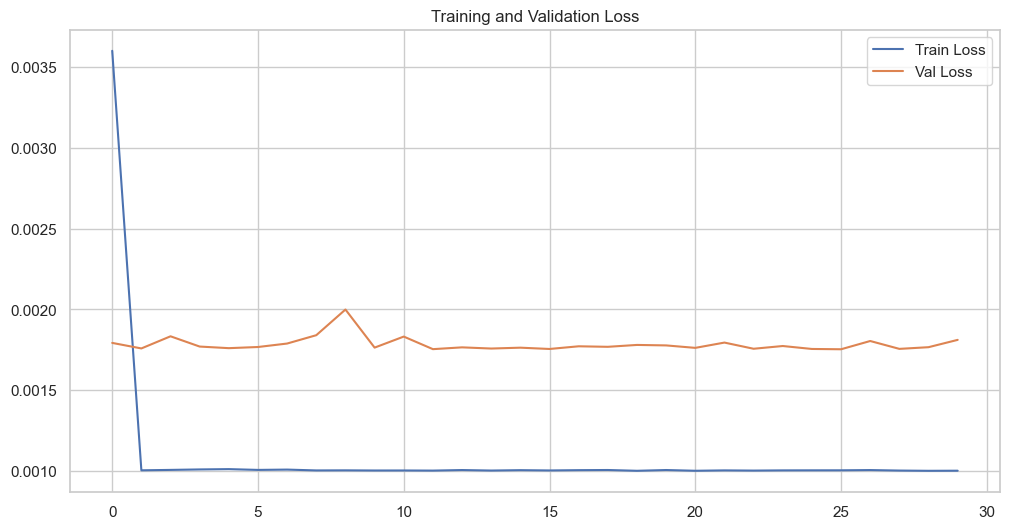

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np

y_pred_nn = model.predict(X_test)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
print(f"Neural Network Test MAE: {mae_nn:.4f} || RMSE: {rmse_nn:.5f}")


470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step
Neural Network Test MAE: 0.0121 || RMSE: 0.04234


470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step


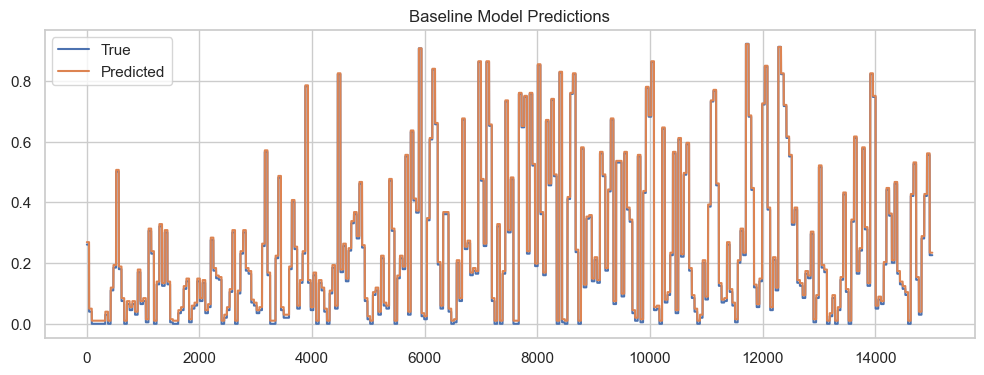

In [12]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.figure(figsize=(12, 4))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Baseline Model Predictions')
plt.legend()
plt.show()


In [13]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_pred_lr = lr_model.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print(f"Linear Regression Test MAE: {mae_lr:.5f} || RMSE: {rmse_lr:.5f} ")


Linear Regression Test MAE: 0.00646 || RMSE: 0.04158 


In [15]:
from IPython.display import Markdown, display

table = f"""
### Model Performance Comparison

| Model                          |  MAE     | RMSE    |  
|--------------------------------|----------|---------| 
| Sequential NN (1-feature, 1-step, MLP) |  {mae_nn:.5f} | {rmse_nn:.5f} |
| Linear Regression              |  {mae_lr:.5f} | {rmse_lr:.5f} |
"""

display(Markdown(table))



### Model Performance Comparison

| Model                          |  MAE     | RMSE    |  
|--------------------------------|----------|---------| 
| Sequential NN (1-feature, 1-step, MLP) |  0.01214 | 0.04234 |
| Linear Regression              |  0.00646 | 0.04158 |


## Evaluation

We evaluate both models using the following metrics:
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)

These metrics provide a clear indication of prediction accuracy and are standard for regression tasks in wind power forecasting.
